In [1]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

基本プロセスの拡張...ここまでは、成長率とボラティリティが一定の無配当型株式オプションの評価のみを行ってきたが、以下の観点で一般化する。

①配当利回りを伴う株式オプション...通常のBSモデルは無配当を前提としているが、ほとんどの株式においては配当を支払う。$\\$
②株価のジャンプ過程...幾何ブラウン運動では表現しきれないジャンプを含んだ過程やボラティリティが一定でないモデルを扱う。$\\$
③平均回帰過程...金利やコモディティなど、ドリフト項の係数が長期金利や理論価格に回帰していく傾向がある。

①配当利回りを伴う株式オプション...配当利回り$\omega$を考慮したBS方程式から導出されるオプション価格は以下のようになる。（RN）
$$dS=(r-\omega)Sdt+\sigma Sdz$$
$$Call(S_0,K,r,T,\sigma)=S_0e^{-\omega T}N(d_1)-Ke^{-rT}N(d_2)$$
$$Put(S_0,K,r,T,\sigma)=Ke^{-rT}N(-d_2)-S_0e^{-\omega T}N(-d_1)$$
ただし、
$$d_1=\cfrac{\ln(S_0/K)+(r-\omega+\sigma^2/2)T}{\sigma\sqrt{T}},\ \ d_2=d_1-\sigma\sqrt{T}$$
また、プット・コール・パリティは以下のようになる。
$$Call(S_0,K,r,T,\sigma)+Ke^{-rT}=Put(S_0,K,r,T,\sigma)+S_0e^{-\omega T}$$

In [281]:
# 解析解を用いたオプション価格（配当利回り考慮）
class BS_Model_div:

    def __init__(self, s0, K, r, T, sigma, omega):
        self.s0 = s0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.omega = omega

    def Call(self, s0, K, r, T, sigma, omega):
        self.s0 = s0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.omega = omega

        d1 = (np.log(s0/K)+(r - omega + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call = s0 * np.exp(-omega*T) * stats.norm.cdf(d1,0,1) - K * np.exp(-r*T) * stats.norm.cdf(d2,0,1)
        return call
    
    def Put(self, s0, K, r, T, sigma, omega):
        self.s0 = s0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.omega = omega

        d1 = (np.log(s0/K)+(r - omega + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        put =  K * np.exp(-r*T) * stats.norm.cdf(-d2,0,1) - s0 * np.exp(-omega*T) * stats.norm.cdf(-d1,0,1)
        return put


In [282]:
s0 = 100
K = 100
r = 0.05
T = 1
sigma = 0.3
omega = 0.03

BS_div = BS_Model_div(s0, K, r, T, sigma, omega)

C = BS_div.Call(s0, K, r, T, sigma, omega)
print(f'Call = {C}')

P = BS_div.Put(s0, K, r, T, sigma, omega)
print(f'Put = {P}')

Call = 12.442646395566044
Put = 10.521035490786637


②株価のジャンプ過程...ここまでは、株価は幾何ブラウン運動に従うという想定でモデリングしており、オプション価格もそれを前提としている。しかし、過去の日経平均株価と日次リターンを見ると、正規分布が示唆するよりも高い確率で（正負に）大きいリターンが発生しており、ボラティリティも一定でない。（特に、1987年10月のブラックマンデー以降、大きなマイナスリターンが発生する現象が顕著である。）すなわち、正規分布を仮定した幾何ブラウン運動だけでは説明できない問題が多い。金融市場では、10年に一度や100年に一度のサプライズが年に何回も起こるが、これは正規分布を前提に話しているため不可解なことが起きるのであって、現実の市場では母集団分布が正規分布と異なることを意味する。

（例）ヒストリカルな株価リターンの分布が、幾何ブラウン運動よりマイナス寄りにスキューしファットテイルとなっている。外国為替のリターン分布が、中心が尖り両裾が厚い（揉み合いが長く続くか、突然大きく動く確率が高い）...etc.

インプライド・ボラティリティ（IV）...オプションの市場取引価格を所与として、理論的なオプションモデルの価格が市場価格と一致するようにボラティリティを逆算したものである。BSモデルを用いた計算方法が一般的であり、他のパラメータが同じならヨーロピアン・コールでもヨーロピアン・プットでもIVは一致する。これはアメリカン・オプションにおいてもほぼ成り立つ。また、IVは一般に解析的に求められないので収束計算を用いる。

$$S_0N(d_1)-Ke^{-rT}N(d_2)=Call(S_0,K,r,T,\sigma)=\text{Market Price}$$

（注）実際には、売買スプレッドの存在や取引された時間によって差が生じる場合もある。

（注）ヒストリカルデータを用いて推定した過去のボラティリティデータと異なり、IVは現在のオプション市場価格を織り込んだものになっている。このため、将来の市場への期待を反映しているとみなされる重要な指標である。

ボラティリティ・スマイル（スキュー）...他のパラメータは固定し、行使価格$K$のみ変化させてIVを描いたグラフを指す。理論的には、コールから算出したものもプットから算出したものも同じになるはずである。また、市場がBSモデルの仮定通りの場合、ボラティリティ・スマイルはx軸に水平な直線となるはずであるが、実際の市場で観測されるものは両端が持ち上がって、まさにスマイルの形状となっている。

（注）ボラティリティ・スマイルは、リターン分布の形状分析にも非常に有用である。つまり、市場がどのように大きなサプライズの発生頻度を見ているかは、オプションのボラティリティ・スマイルで確認することが可能である。

[0.466649811694604, 0.45702827972213367, 0.4251242950109041, 0.403438423228086, 0.3884553042384613, 0.36176199584674623, 0.33755452596471264, 0.31951257878319494, 0.29509110691131124, 0.2774778100341865, 0.24091430616951126, 0.22843961848931998, 0.22417568659291454, 0.21799892274261695, 0.2326881389573603, 0.23847853050269213, 0.25046913788422664, 0.26111814262629923, 0.2879974542887275]
[0.66858233 0.70377087 0.73895942 0.77414796 0.80933651 0.84452505
 0.87971359 0.91490214 0.95009068 0.98527922 1.02046777 1.05565631
 1.09084486 1.1260334  1.16122194 1.19641049 1.23159903 1.26678757
 1.30197612]


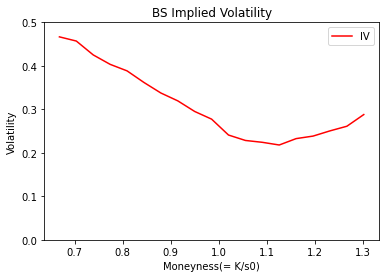

In [278]:
# BSモデルによるボラティリティ・スマイル
# 簡単のため、配当率は未考慮
from common.numerical_func import binary_search
from common.option_price import BS_Model

op_mkt_price = [2, 5, 8, 15, 30, 50, 85, 150, 245, 405, 315, 145, 60, 20, 10, 4, 2, 1, 1]

Ks = [9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000,
      14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500]

C = 1
P = 0
C_or_P = [P, P, P, P, P, P, P, P, P, P, C, C, C, C, C, C, C, C, C]

def F(s0, K, r, T, sigma, op_mkt, CP):
    BS = BS_Model(s0, K, r, T, sigma)
    if CP == C:
        BS_op = BS.Call(s0, K, r, T, sigma)
    elif CP == P:
        BS_op = BS.Put(s0, K, r, T, sigma)
    y = op_mkt - BS_op
    return y


s0 = 14209.17
r = 0.001
T = 0.104
s_lower = 0.001
s_upper = 5.00
eps = 1e-10
a = s_lower
b = s_upper
xs = []

for i in range(len(Ks)):
    def f(sigma):
        K = Ks[i]
        op_mkt = op_mkt_price[i]
        CP = C_or_P[i]
        return F(s0, K, r, T, sigma, op_mkt, CP)
    
    sigma = binary_search(a, b, f, s_lower, s_upper, eps)
    xs.append(sigma)

Ks = np.array(Ks)
Moneyness = Ks / s0
print(xs)
print(Moneyness)

# グラフの描画
plt.figure()
plt.plot(Moneyness, xs, color='red', label='IV')
plt.ylim(0, 0.5)
plt.xlabel('Moneyness(= K/s0)')
plt.ylabel('Volatility')
plt.title('BS Implied Volatility')
plt.legend()
plt.show()


In [280]:
# インプライド分布と正規分布（未完成）
# from common.option_price import BS_Model
# dt = 1
# mu = r
# N = 1
# T = 10
# C_neighbor_vec = []
# Ks = np.arange(4000,15000,50)
# # Ks = [400]
# # Ks = [9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000,
#     #   14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500]

# sigma=0.3
# for i in range(N):
#     for K in Ks:
#         BS_Call = BS_Model(s0, K, r, T, sigma)
#         C = BS_Call.Call(s0, K, r, T, sigma)
#         BS_Call = BS_Model(s0, K+150, r, T, sigma)
#         C_plus = BS_Call.Call(s0, K+150, r, T, sigma)
#         BS_Call = BS_Model(s0, K-150, r, T, sigma)
#         C_minus = BS_Call.Call(s0, K-150, r, T, sigma)
#         C_neighbor = 1e+1*(C_plus + C_minus -2*C)
        
#         C_neighbor_vec.append(C_neighbor)

# C_neighbor_vec = np.array(C_neighbor_vec)
# mean = np.mean(C_neighbor_vec)
# std = np.std(C_neighbor_vec)
# print('平均: {0:.2f}'.format(mu))
# print('標準偏差: {0:.2f}'.format(std))
# # print(C_neighbor_vec)

# x = np.arange(-5,20,1)
# plt.hist(C_neighbor_vec, bins=25, rwidth=0.6, density=True)
# plt.plot(x, stats.norm.pdf(x, mean, std), color='red', label='Normal Distribution')
# plt.show()

In [3]:
# バイナリーサーチの確認
# 微分係数が求まる場合は、Newton法の方が早い
# f(a)f(b)<0の場合、f(x)=0の解はa<x<bに存在する
# 解の探索範囲を半分に分割していく

def binary_search(a, b, F, s_lower, s_upper, eps):
    c = 100 # 計算上限
    not_finish = True
    count = 0

    while not_finish and (count <= c):
        bin = (s_lower + s_upper) / 2
        y = F(bin)
        if np.abs(y) <= eps:
            x = bin # 解発見
            not_finish = False
        elif F(s_lower)*y < 0:
            s_upper = bin
        else:
            s_lower = bin
        count = count + 1
    if not_finish:
        x = "Nan"
    return x



In [6]:
# バイナリーサーチの例
def f(x):
    return np.exp(x**2) -7*x**2 + 3*x +1 

x1 = binary_search(-2, 2, f, -2, -1, 1e-9)
x2 = binary_search(-2, 2, f, -1, 0, 1e-9)
x3 = binary_search(-2, 2, f, 0, 1.4, 1e-9)
x4 = binary_search(-2, 2, f, 1.4, 2, 1e-9)

print(x1)
print(x2)
print(x3)
print(x4)

-1.8227206548908725
-0.380610607098788
0.949690083693713
1.557304988009855


（注）ボラティリティ・スマイルの原因

①ジャンプ...資産価格は、幾何ブラウン運動が仮定している連続的な変化だけでなく、時としてジャンプのような不連続な変化が起こる。（戦争やリーマンショックなどの金融危機、為替介入などのような大きなサプライズに対して、株価は徐々に値を下げず、一気に下落する。）

②確率ボラティリティ...資産価格のボラティリティは一定でなく、確率過程に従っている。これの1つの理由として、株価が大きく下がると負債比率が高くなり、ボラティリティが増す現象（レバレッジ効果）が原因である。

ボラティリティ・サーフィス...ボラティリティ・スマイルを、オプションの満期までの時間ごとに描いた曲面グラフを指す。これは、ボラティリティの期間構造を表しており、例えば以下の特徴がある。

ボラティリティには平均回帰性があり、現在のボラティリティが過去と比較して高い場合は、今後低下することが予測される。（期間構造は下向きの傾斜となる）

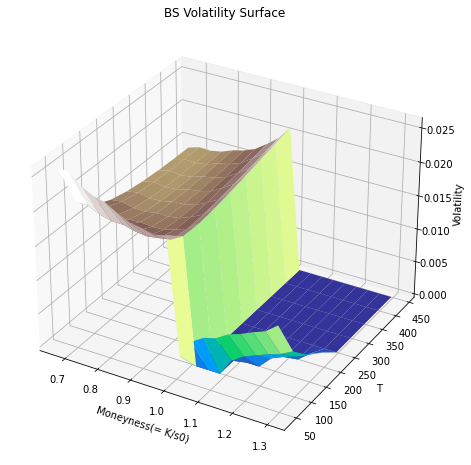

In [30]:
# BSモデルによるボラティリティ・サーフィス
# 簡単のため、配当率は未考慮
from common.numerical_func import binary_search
from common.option_price import BS_Model

op_mkt_price = [2, 5, 8, 15, 30, 50, 85, 150, 245, 405, 315, 145, 60, 20, 10, 4, 2, 1, 1]

Ks = [9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000,
      14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500]

C = 1
P = 0
C_or_P = [P, P, P, P, P, P, P, P, P, P, C, C, C, C, C, C, C, C, C]

def F(s0, K, r, T, sigma, op_mkt, CP):
    BS = BS_Model(s0, K, r, T, sigma)
    if CP == C:
        BS_op = BS.Call(s0, K, r, T, sigma)
    elif CP == P:
        BS_op = BS.Put(s0, K, r, T, sigma)
    y = op_mkt - BS_op
    return y


s0 = 14209.17
r = 0.001
# T = 0.104
s_lower = 0.001
s_upper = 5.00
eps = 1e-10
a = s_lower
b = s_upper
xs = []
Ts = np.arange(40 ,490, 50)

for t in Ts:
    for i in range(len(Ks)):
        def f(sigma):
            K = Ks[i]
            op_mkt = op_mkt_price[i]
            CP = C_or_P[i]
            return F(s0, K, r, t, sigma, op_mkt, CP)
        
        sigma = binary_search(a, b, f, s_lower, s_upper, eps)
        xs.append(sigma)
    
    Ks = np.array(Ks)
    Moneyness = Ks / s0

xs = np.array(xs)
xs = xs.reshape([9, 19])

x = Moneyness
y = Ts
X, Y = np.meshgrid(x, y)

z = xs
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.plot_surface(X, Y, z, cmap='terrain')

ax.set_title('BS Volatility Surface')

ax.set_xlabel('Moneyness(= K/s0)')
ax.set_ylabel('T')
ax.set_zlabel('Volatility')

plt.show()

以下では、ジャンプと確率ボラティリティを加えたモデルを考える。（さらに高度化すると金利も確率過程となるものもある。）

ジャンプ拡散過程（Jump-Diffusion process）...価格が連続的に変化する幾何ブラウン運動拡散過程にジャンプを加えたもの。

$$dS=\mu Sdt+\sigma SdZ+(y-1)SdN$$

$N$はジャンプが発生したかどうかを表すPoisson過程で、年間での発生回数を$\lambda$とすると、微小区間$dt$においては以下のようになる。

$$dN=\begin{cases}
   0 \ \ \ \text{with prob }1-\lambda dt\\
   1 \ \ \ \text{with prob }\lambda dt
\end{cases}$$

$y$はジャンプの絶対価格サイズを表し、例えば$y=0.7$の場合、ジャンプが発生すると資産価格は即座に0.7倍となる。（すなわち、ジャンプによる増分は$y-1=-30$%）

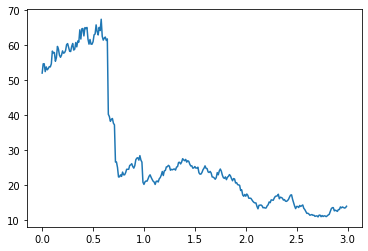

In [65]:
# シンプルなジャンプ
s0= 50
mu = 0.15
sigma = 0.3
lmd = 1 # 年間発生回数
y = 0.7 # ジャンプサイズ
T = 3
dt = 0.01

jvec = []
svec = []
dsvec = []

s = s0
for j in range(T*100):
    uni = np.random.uniform(0,1)
    eps = np.random.normal(0,1,1)
    dN = uni < lmd*dt # Poisson Process
    dJ = (y-1) * dN
    ds = 1 + mu * dt + sigma * eps * np.sqrt(dt) + dJ # ジャンプ項を追加
    s = s * ds
    jvec.append(j*dt)
    svec.append(s)
    dsvec.append(ds)

plt.plot(jvec, svec)
plt.show()

（注）上の場合、ジャンプサイズが一定と仮定したが、現実ではサイズが確率的な場合の方が相応しい。以下では、ジャンプサイズが確率的なMertonのジャンプ拡散モデルについて考察する。


ジャンプ拡散モデル...ジャンプサイズが対数正規分布に従う。（ジャンプの対数サイズが正規分布に従う。）すなわち、ジャンプのインパクト時に正規分布のような不確実性が想定される。

微小時間$dt$にジャンプが発生したとき、資産価格$S_t$は$y_tS_t$に変化すると仮定する。ジャンプによる資産価格の変化は
$$\cfrac{dS_t}{S_t}=\cfrac{y_tS_t-S_t}{S_t}=y_t-1$$
ただし、
$$\lg(y_t)\verb|~|  N(\nu,\ \xi^2)\ \ \ i.i.d.$$
$$E[y_t]=e^{\nu+\frac{\xi^2}{2}}$$
$$V[y_t]=e^{2\nu+\xi^2}(e^{\xi^2}-1)$$

基本的な幾何ブラウン運動による拡散過程に、複合Poisson過程を加えたジャンプ拡散過程は以下のようになる。
$$\cfrac{dS_t}{S_t}=(\mu-\lambda\kappa)dt+\sigma dZ_t+(y_t-1)dN_t$$
ただし、
$\mu$、$\sigma$はジャンプが発生しない場合の瞬間的な資産の期待リターンとボラティリティ、$\lambda$は１年間に発生するジャンプの期待回数、$\kappa$はジャンプの（期待）サイズを表す。


（注）ドリフト項の係数が$\mu-\lambda\kappa$の理由は以下で説明できる。リスク中立化のため、ドリフト項に対するジャンプの影響をなくすために、ジャンプの期待インパクトを差し引くと
$$E\left[\cfrac{dS_t}{S_t}\right]=E[(\mu-\lambda\kappa)dt]+E[\sigma dZ_t]+E[(y_t-1)dN_t]=(\mu-\lambda\kappa)dt+0+\lambda\kappa dt=\mu dt$$
となり、ジャンプが予測不可能な独立したものとして取り扱われることになる。また、配当やコンビニエンス・イールドがある場合
$$\cfrac{dS_t}{S_t}=(\mu-\omega-\lambda\kappa)dt+\sigma dZ_t+(y_t-1)dN_t$$
リスク中立プロセスの場合
$$\cfrac{dS_t}{S_t}=(r-\omega-\lambda\kappa)dt+\sigma dZ_t+(y_t-1)dN_t$$

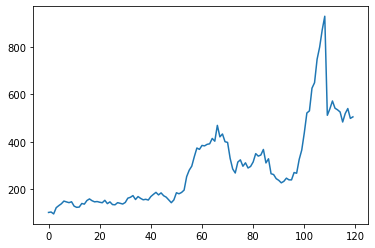

In [123]:
# マートンジャンプ拡散（MJD）過程
T = 10
s0 = 100
mu = 0.15
sigma = 0.3
dt = 1/12
lmd = 0.2
nu =-0.5
xi = 0.1
n = 2 # 分割数
N = int(T / dt)

jvec = []
svec = []
dsvec = []

# サブピリオドに分割して、ジャンプが発生したか調べる
sub_lmd = lmd * dt / n
s = s0
for i in range(N):
    j_size = 0
    for j in range(n):
        uni = np.random.uniform(0,1)
        eps = np.random.normal(0,1,1)
        if uni < sub_lmd:
            j_size = j_size + nu + xi * eps
    kappa = np.exp(nu + xi**2 / 2) - 1
    ds = np.exp((mu - lmd*kappa - sigma**2 / 2) * dt + sigma * eps * np.sqrt(dt) + j_size)
    s = s * ds
    jvec.append(i)
    svec.append(s)
    dsvec.append(ds)

plt.plot(jvec, svec)
plt.show()


マートンジャンプ拡散（MJD）オプション評価モデル...一般に、ジャンプ拡散過程をもとにしたオプション評価は、完璧なヘッジが行えない不完備市場における問題となり、1つの解が定まらない。（複数のマルチンゲール測度をもつ）一方、マートンジャンプは、ジャンプによる資産価格プロセス$dN_t$は市場全体と独立したアンシステマティック・リスクなので、そのリスクプレミアムはゼロとなる。オプション価格の解析解は、満期までにジャンプが起こる回数に応じた確率と、BS価格との加重合計となる。

$$V_{Merton}=\displaystyle{\sum_{n=0}^\infty}\cfrac{e^{-\lambda^{\prime}\tau}(\lambda^{\prime}\tau)^n}{n!}V_{BS}(S_t,K,\tau=T-t,r_n,\sigma_n)$$
ただし、
$$\lambda^{\prime}=\lambda(1+\kappa)=\lambda e^{\nu+\frac{\xi^2}{2}}$$
$$r_n=r-\lambda \left(e^{\nu+\frac{\xi^2}{2}}-1\right)+\frac{n}{\tau}\left(\nu+\frac{\xi^2}{2}\right)$$
$$r_n=r-\sqrt{\left(1+\frac{n}{\tau}\right)\sigma^2}$$

In [125]:
# MJDコール（解析解）
# プットも同様
from common.option_price import BS_Model

tau = 10 # 行使期限までの時間
s0 = 100
r = 0.05
sigma = 0.3
K = 100
lmd = 0.5
nu = -0.3
xi = 0.1

BS_Call = BS_Model(s0, K, r, T, sigma)
C = BS_Call.Call(s0, K, r, tau, sigma)
print('BSモデル: {0:.2f}'.format(C))

class MJD_Model:

    def __init__(self, s0, K, r, T, sigma, lmd, nu, xi):
        self.s0 = s0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.lmd = lmd
        self.nu = nu
        self.xi = xi

    def Call(self, s0, K, r, T, sigma, lmd, nu, xi):
        self.s0 = s0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.lmd = lmd
        self.nu = nu
        self.xi = xi

        kappa = np.exp(nu + xi**2 / 2) - 1
        lmd_p = lmd * (1+kappa)

        log_n = 0
        VmC = 0
        for i in range(51):     # 無限和の部分は50個の和で
            sigma_n = np.sqrt(sigma**2 + i / T * xi**2)
            rn = r - lmd * kappa + i / T * (nu + xi**2 / 2)

            if i > 0:
                log_n = log_n + np.log(i)
            BS_C = BS_Call.Call(s0, K, rn, T, sigma_n)
            VmC = VmC + np.exp(-lmd_p * T + i * np.log(lmd_p * T) - log_n) * BS_C
        MJD_Call = VmC
        return MJD_Call

MJD = MJD_Model(s0, K, r, T, sigma, lmd, nu, xi)
MJD_Call = MJD.Call(s0, K, r, T, sigma, lmd, nu, xi)
print('MJDモデル: {0:.2f}'.format(MJD_Call))

BSモデル: 52.57
MJDモデル: 57.57


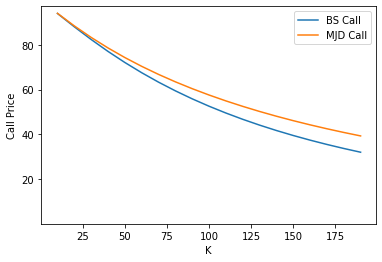

In [126]:
# BSモデルよりMJDモデルの方がコール価格が高い
# これはジャンプが新たにボラティリティを加えるためである
Ks = np.arange(10, 200, 10)

BS_vec = []
MJD_vec = []

for K in Ks:
    BS_Call = BS_Model(s0, K, r, T, sigma)
    C = BS_Call.Call(s0, K, r, tau, sigma)
    BS_vec.append(C)
    MJD = MJD_Model(s0, K, r, T, sigma, lmd, nu, xi)
    MJD_Call = MJD.Call(s0, K, r, T, sigma, lmd, nu, xi)
    MJD_vec.append(MJD_Call)

plt.plot(Ks, BS_vec, label='BS Call')
plt.plot(Ks, MJD_vec, label='MJD Call')
plt.xlim(0.200)
plt.ylim(0.100)
plt.xlabel('K')
plt.ylabel('Call Price')
plt.legend()
plt.show()


③平均回帰過程...ここまで、ドリフト項の係数は一定（資産価格が時間の経過と共に一定の上昇率で上がり続ける）という過程であった。一方、金利やコモディティなど、ドリフトが長期金利や理論価格に回帰していく傾向があり、これを平均回帰性という。ここでは平均が一定となるモデルを扱う。
$$d\mu_t=\eta(\bar{\mu}-\mu_t)dt$$
ただし、$\mu_t$は時刻$t$における期待リターン、$\bar{\mu}$は長期の平均値、$\eta$は平均回帰速度である。ここで、$\eta$の大きさによって長期の平均値に収束する速さが決まることがわかる。平均に向かってどれくらい（何年）のスピードで回帰していくのかを表す指標として、半減期というものがある。

半減期は$\eta$の関数で、長期平均からの乖離が半分になる年数である。（$\log2/\eta$の期間で半減する。）


$\mu_t=\bar{\mu}-\mu_t$とおいて
$$d\mu_t=-\eta\mu_t dt$$
これは変数分離の形の常微分方程式なので、適当な初期条件を設定して
$$\mu_t=e^{-\eta t}$$
$T$を半減期とすると
$$\cfrac{1}{2}=e^{-\eta T}$$
$$\mu_t=e^{-\eta t}=(e^{-\eta T})^{(t/T)}=\left(\cfrac{1}{2}\right)^{(t/T)}$$
なお、半減期$T$は$\eta$を用いて
$$T=\cfrac{\ln2}{\eta}$$


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  if __name__ == '__main__':
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


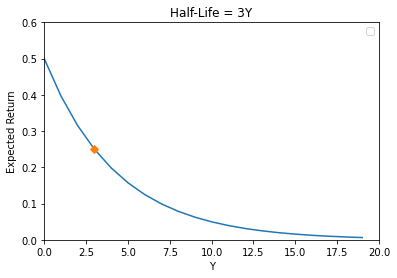

In [290]:
# グラフの描画
# 赤のマーカーの部分で期待リターンが半減している
plt.figure()
mu = 0.5
T = 3.0 # 半減期
t = np.arange(0, 20, 1)
y = mu * (0.5)**(t/T)

plt.plot(x, y)
plt.plot(T, mu * (0.5)**(T/T), '.', linestyle='solid', marker="D")
plt.xlim(0, 20)
plt.ylim(0, 0.6)
plt.xlabel('Y')
plt.ylabel('Expected Return')
plt.title('Half-Life = 3Y')
plt.legend()
plt.show()

Ornstein-Uhlenbeck平均回帰過程...以下の伊藤過程で統計値と（正確な離散式は）以下の通り
$$\begin{cases}dx_t=\eta(\bar{x}-x_t)dt+\sigma dz_t\\ x_0=0\end{cases}$$
$$E[x_t]=x_0e^{-\eta t}+\bar{x}(1-e^{-\eta t}),\ \ \ V[x_t]=(1-e^{-2\eta t})\cfrac{\sigma^2}{2\eta}$$
$$x_{t+\Delta t}=x_te^{-\eta\Delta t}+\bar{x}(1-e^{-\eta\Delta t})+\sigma\varepsilon\sqrt{\cfrac{1-e^{-2\eta\Delta t}}{2\eta}}$$

期待値は、初期値と長期平均との時間及び平均回帰速度ウェイトの加重平均である。また、分散は時間に関して単調増加で$\sigma^2/2\eta$に収束する。さらに、
$$\displaystyle{\lim_{\eta\rightarrow\infty}}V[x_t]=0,\ \ \ \lim_{\eta\rightarrow 0}V[x_t]=\sigma^2t$$


（注）上の式では、$x_t$がマイナスの値を取りうるので、マイナス金利やコモディティの場合は、$x_t=\ln S_t$とおくと、リアルワールドとリスクニュートラルの場合それぞれ
$$S_{t+\Delta t}=\exp\left[\ln S_te^{-\eta\Delta t}+\ln\bar{S}(1-e^{-\eta\Delta t})-(1-e^{-2\eta\Delta t})\cfrac{\sigma^2}{4\eta}+\sigma\varepsilon\sqrt{\cfrac{1-e^{-2\eta\Delta t}}{2\eta}}\right],$$
$$S_{t+\Delta t}=\exp\left[\ln S_te^{-\eta\Delta t}+\left(\ln\bar{S}-\cfrac{\mu-r}{\eta}\right)(1-e^{-\eta\Delta t})-(1-e^{-2\eta\Delta t})\cfrac{\sigma^2}{4\eta}+\sigma\varepsilon\sqrt{\cfrac{1-e^{-2\eta\Delta t}}{2\eta}}\right]$$

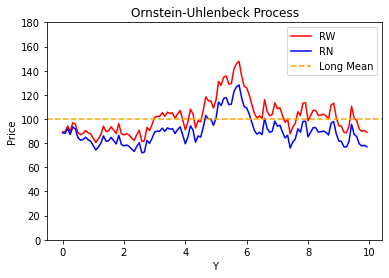

In [163]:
# Ornstein-Uhlenbeck平均回帰過程
s0 = 80
sigma = 0.25
eta = np.log(2) / 1
halflife = np.log(2) / eta
longmean = 100
r = 0.05
mu = 0.15
dt = 1/12

# 同じ正規乱数を使うため格納
eps_vec = []
ivec = []
for i in range(120):
    eps = np.random.normal(0,1,1)
    eps_vec.append(eps)
    ivec.append(i*dt)

# RW
s = s0
RW_vec = []
for i in range(120):
    term1 = np.log(s) * np.exp(-eta * dt)
    term2 = np.log(longmean) * (1 - np.exp(-eta * dt))
    term3 = -(1 - np.exp(-2 * eta * dt)) * sigma**2 / (4 * eta)
    term4 = sigma * eps_vec[i] * np.sqrt((1 - np.exp(-2 * eta * dt)) / (2 * eta))
    s = np.exp(term1 + term2 + term3 + term4)
    RW_vec.append(s)

# RN
s = s0
RN_vec = []
for i in range(120):
    term1 = np.log(s) * np.exp(-eta * dt)
    term2 = (np.log(longmean) - (mu - r)/eta) * (1 - np.exp(-eta * dt))
    term3 = -(1 - np.exp(-2 * eta * dt)) * sigma**2 / (4 * eta)
    term4 = sigma * eps_vec[i] * np.sqrt((1 - np.exp(-2 * eta * dt)) / (2 * eta))
    s = np.exp(term1 + term2 + term3 + term4)
    RN_vec.append(s)


plt.plot(ivec, RW_vec, color='red', label='RW')
plt.plot(ivec, RN_vec, color='blue', label='RN')
plt.ylim(0,180)
plt.axhline(longmean, color='orange', linestyle='--', label='Long Mean')
plt.xlabel('Y')
plt.ylabel('Price')
plt.title('Ornstein-Uhlenbeck Process')
plt.legend()
plt.show()

（注）ドリフトの違いにより、RNのパスはRWのパスの下にあり、時間経過と共にその差も開いていく。

確率ボラティリティ...BSモデルのように、ボラティリティが時間に依らず一定という仮定は非現実的である。さらに時間による変動は完全ランダムでなく、大きい時期や小さい時期など固まりを作る傾向がある。（ボラティリティ・クラスタリングという）これはボラティリティの自己相関性に起因する。また、株価の下落に伴い、ボラティリティが増加する傾向もある。（レバレッジ効果という）これは資産価格とボラティリティに負の相関があることに起因する。

Heston確率ボラティリティモデル...BSモデルに確率的な平均回帰ボラティリティ過程を加えたもの。
$$dS_t=(r-\omega)S_tdt+\sqrt{V_t}S_tdz_{S,t}$$
$$dV_t=\kappa(\theta-V_t)dt+\xi\sqrt{V_t}dz_{V,t}$$
$$dz_{S,t}\cdot dz_{V,t}=\rho dt$$
ただし、$S_t$は資産価格、$V_t$は分散、$\theta$は分散の長期平均、$\kappa$は回帰速度、$\xi$は分散のボラティリティ。ここで、分散は金利のCox-Ingersoll-Ross（CIR）モデルと同じ平均回帰過程で、マイナスの値を取らない。平均回帰性より、大きなボラティリティがしばらく続いたり小さなボラティリティがしばらく続いたりして、ボラティリティ・クラスタリングが表現できる。また、一般に2つのWinner過程$dz_{S,t}$、$dz_{V,t}$の瞬間相関係数$\rho$は$-0.5$以下で、資産価格とボラティリティに負の相関がある。

Heston確率ボラティリティモデルをEuler法で近似すると以下の通りになる。
$$\ln S_{t+\Delta t}=\ln S_t+(r-\omega-0.5V_t^+)\Delta t+\sqrt{V_t^+}\varepsilon_S\sqrt{\Delta t}$$
$$V_{t+\Delta t}=V_t+\kappa(\theta-V_t^+)\Delta t+\xi\sqrt{V_t^+}\varepsilon_V\sqrt{\Delta t}$$
$$\varepsilon_V=\phi^{-1}(U_1)$$
$$\varepsilon_S=\rho\varepsilon_V+\sqrt{1-\rho^2}\phi^{-1}(U_2)$$
$$V_t^+=\max(V_t,0)$$
ただし、負の値の平方根を取らないようにゼロフロアを設定している。また、正確な離散化としてBroadie-Kayaスキームや、Euler法より高精度のAnderson-QEスキームなどがある。

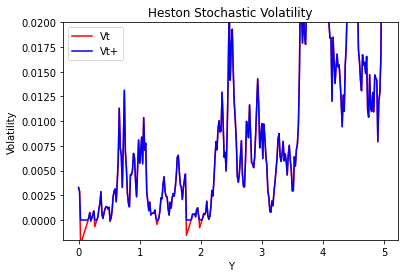

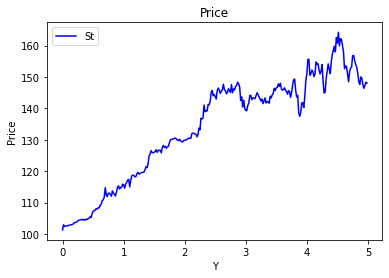

In [242]:
# Heston確率ボラティリティモデル
T = 5 # グラフ用に5年にした
dt = T / 300
s0 = 100
rho = 0
r = 0.05
omega = 0 # 配当利回り
v0 = 0.01
theta = 0.01
kappa = 2.0
xi = 0.225

tstep = int(T/dt)
lns = np.log(s0) # 対数株価
v = v0
pv = max(v0, 0) # 正の分散

j_vec = []
v_vec = []
pv_vec = []
s_vec = []

for j in range(tstep):
    eps_v = np.random.normal(0,1,1)
    # 相関正規乱数の生成
    eps = np.random.normal(0,1,1)
    eps_s = rho * eps_v + np.sqrt(1 - rho**2) * eps

    lns = lns + (r - omega - 0.5 * pv) * dt + np.sqrt(pv) * np.sqrt(dt) * eps_s
    v = v + kappa * (theta - pv) * dt + xi * np.sqrt(pv) * np.sqrt(dt) * eps_v
    pv = max(v, 0)
    s = np.exp(lns) # 対数株価から通常の株価に戻す

    j_vec.append(j*dt)
    v_vec.append(v)
    pv_vec.append(pv)
    s_vec.append(s)

# 確率ボラティリティ
plt.plot(j_vec, v_vec, color='red', label='Vt')
plt.plot(j_vec, pv_vec, color='blue', label='Vt+')
plt.ylim(-0.002, 0.02, 0.002)
plt.xlabel('Y')
plt.ylabel('Volatility')
plt.title('Heston Stochastic Volatility')
plt.legend()
plt.show()

# 資産価格
plt.plot(j_vec, s_vec, color='Blue', label='St')
plt.xlabel('Y')
plt.ylabel('Price')
plt.title('Price')
plt.legend()
plt.show()

相関係数$\rho$の影響...前述の通り、負の相関を持つとき、株価が下がったときにボラティリティは上昇する。（これは現実の市場の暴落の様子に整合的である。）これは、リターン分布が負のスキュー（歪度）を持つことを意味し、正規分布に比べてマイナスリターンの確率が高い。


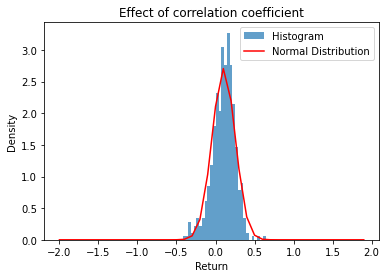

In [264]:
# Heston確率ボラティリティモデルで負の相関を考慮すると、BSモデルの正規分布より負のスキューを確認することができる
def ret(rho):
    T = 1
    dt = T / 300
    s0 = 100
    r = 0.05
    omega = 0 # 配当利回り
    v0 = 0.01
    theta = 0.01
    kappa = 2.0
    xi = 0.225

    tstep = int(T/dt)
    lns = np.log(s0) # 対数株価
    v = v0
    pv = max(v0, 0) # 正の分散

    for j in range(tstep):
        eps_v = np.random.normal(0,1,1)
        # 相関正規乱数の生成
        eps = np.random.normal(0,1,1)
        eps_s = rho * eps_v + np.sqrt(1 - rho**2) * eps

        lns = lns + (r - omega - 0.5 * pv) * dt + np.sqrt(pv) * np.sqrt(dt) * eps_s
        v = v + kappa * (theta - pv) * dt + xi * np.sqrt(pv) * np.sqrt(dt) * eps_v
        pv = max(v, 0)
        s = np.exp(lns) # 対数株価から通常の株価に戻す
    s_b = s

    T = 2
    dt = T / 300
    tstep = int(T/dt)

    for j in range(tstep):
        eps_v = np.random.normal(0,1,1)
        # 相関正規乱数の生成
        eps = np.random.normal(0,1,1)
        eps_s = rho * eps_v + np.sqrt(1 - rho**2) * eps

        lns = lns + (r - omega - 0.5 * pv) * dt + np.sqrt(pv) * np.sqrt(dt) * eps_s
        v = v + kappa * (theta - pv) * dt + xi * np.sqrt(pv) * np.sqrt(dt) * eps_v
        pv = max(v, 0)
        s = np.exp(lns) # 対数株価から通常の株価に戻す
    s_f = s

    ret = (s_f - s_b) / s_b # 1年リターンの算出
    return ret

ret_vec = []
for t in range(500):
    r = ret(rho=-0.5) # 負の相関
    ret_vec.append(r)

ret_vec = np.array(ret_vec)

# リターン価格の分布
data1 = ret_vec

# 平均値と標準偏差の計算
mean1 = np.mean(data1)
std1 = np.std(data1)

# グラフの描画
plt.figure()
plt.hist(data1, bins=30, density=True, alpha=0.7, label='Histogram')
x = np.arange(-2, 2, 0.1)
plt.plot(x, stats.norm.pdf(x, mean1, std1), color='red', label='Normal Distribution')
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Effect of correlation coefficient')
plt.legend()
plt.show()

分散ボラティリティ$\xi$の影響...大きいほど正規分布に比べ中心が尖り、尖度に影響を与える。

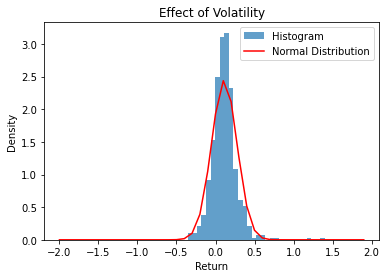

In [265]:
# Heston確率ボラティリティモデルで分散のボラティリティを考慮すると、尖度への影響を確認することができる
def ret(xi):
    T = 1
    dt = T / 300
    s0 = 100
    r = 0.05
    omega = 0 # 配当利回り
    v0 = 0.01
    theta = 0.01
    kappa = 2.0
    rho = 0

    tstep = int(T/dt)
    lns = np.log(s0) # 対数株価
    v = v0
    pv = max(v0, 0) # 正の分散

    for j in range(tstep):
        eps_v = np.random.normal(0,1,1)
        # 相関正規乱数の生成
        eps = np.random.normal(0,1,1)
        eps_s = rho * eps_v + np.sqrt(1 - rho**2) * eps

        lns = lns + (r - omega - 0.5 * pv) * dt + np.sqrt(pv) * np.sqrt(dt) * eps_s
        v = v + kappa * (theta - pv) * dt + xi * np.sqrt(pv) * np.sqrt(dt) * eps_v
        pv = max(v, 0)
        s = np.exp(lns) # 対数株価から通常の株価に戻す
    s_b = s

    T = 2
    dt = T / 300
    tstep = int(T/dt)

    for j in range(tstep):
        eps_v = np.random.normal(0,1,1)
        # 相関正規乱数の生成
        eps = np.random.normal(0,1,1)
        eps_s = rho * eps_v + np.sqrt(1 - rho**2) * eps

        lns = lns + (r - omega - 0.5 * pv) * dt + np.sqrt(pv) * np.sqrt(dt) * eps_s
        v = v + kappa * (theta - pv) * dt + xi * np.sqrt(pv) * np.sqrt(dt) * eps_v
        pv = max(v, 0)
        s = np.exp(lns) # 対数株価から通常の株価に戻す
    s_f = s

    ret = (s_f - s_b) / s_b # 1年リターンの算出
    return ret

ret_vec = []
for t in range(500):
    r = ret(xi=0.4) # 大きな分散ボラティリティ
    ret_vec.append(r)

ret_vec = np.array(ret_vec)

# リターン価格の分布
data1 = ret_vec

# 平均値と標準偏差の計算
mean1 = np.mean(data1)
std1 = np.std(data1)

# グラフの描画
plt.figure()
plt.hist(data1, bins=30, density=True, alpha=0.7, label='Histogram')
x = np.arange(-2, 2, 0.1)
plt.plot(x, stats.norm.pdf(x, mean1, std1), color='red', label='Normal Distribution')
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Effect of Volatility')
plt.legend()
plt.show()